In [115]:
# %%
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs, get_unit_tbl, get_session_tbl, makeSessionDF
from utils.ephys_functions import plot_rate, correlate_nan_bi, correlate_nan, load_drift, get_spike_matrix
from utils.lick_utils import load_licks
from utils.photometry_utils import bin_timeseries_around_align
from utils.pupil_utils import load_pupil
from utils.combine_tools import apply_qc
from utils.plot_utils import combine_pdf_big
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib import colormaps
import pickle
import shutil
import datetime
import seaborn as sns
from trimesh import load_mesh
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from aind_ephys_utils import align
import numbers
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
import pickle
%matplotlib widget

# Load data

In [116]:
data_df = pd.read_csv('/root/capsule/code/data_management/hopkins_session_assets.csv')
sessions = data_df['session_id'].values.tolist()

In [117]:
# load pupil and neuron correlation data


In [118]:
pupil_results = []
pupil_beh_fit = []
T_params_choice_resp = {'outcome': [1, 2.5],
                'svs': [0, 1.5],
                'choice': [0, 1.5],
                'choice:outcome': [1, 2.5]}
T_params_choice_bl = {'svs': [-2, 0]}
T_params_all_resp = {'hit': [0, 1.5]}
T_params_all_bl = {'hit': [-2, 0]}
all_params = {'choice_resp': T_params_choice_resp,
              'choice_bl': T_params_choice_bl,
              'all_resp': T_params_all_resp,
              'all_bl': T_params_all_bl}
for session in sessions:
    session_dir = session_dirs(session)
    pupil_file = os.path.join(session_dir['ephys_processed_dir_curated'], f'{session}_unit_pupil_correlation_results.pickle')
    curr_fit = {}
    if os.path.exists(pupil_file):
        with open(pupil_file, 'rb') as f:
            curr_pupil_data = pickle.load(f)
        pupil_results.append(curr_pupil_data)
    else:
        continue
        

    # pupil-beh fit
    pupil_model_file = os.path.join(session_dir['beh_fig_dir'], f'{session}_pupil_lm_results.pkl')
    if not os.path.exists(pupil_model_file):
        continue
    with open(pupil_model_file, 'rb') as f:
        curr_pupil_model_data = pickle.load(f)
    choice_fit = curr_pupil_model_data['lm_results']
    all_fit = curr_pupil_model_data['lm_results_all']

    # extract T statistics
    for model_type, params in all_params.items():
        if model_type == 'choice_resp':
            fit_data = choice_fit
        elif model_type == 'choice_bl':
            fit_data = choice_fit
        elif model_type == 'all_resp':
            fit_data = all_fit
        elif model_type == 'all_bl':
            fit_data = all_fit
        if fit_data is None:
            continue
        for param_name, time_window in params.items():
            time_vec = fit_data['time']
            time_mask = (time_vec >= time_window[0]) & (time_vec <= time_window[1])
            if fit_data['regressors'] is None:
                continue
            if param_name not in fit_data['regressors']:
                continue
            param_ind = fit_data['regressors'].index(param_name)
            t_stats = fit_data['TvCurrU'][:, param_ind]
            mean_t_stat = np.nanmean(t_stats[time_mask])
            max_t_stat_ind = np.nanargmax(np.abs(t_stats[time_mask]))
            max_t_stat = t_stats[time_mask][max_t_stat_ind]
            min_p = np.nanmin(fit_data['PvCurrU'][:, param_ind][time_mask])
            curr_fit[f'{model_type}_{param_name}'] = max_t_stat
            curr_fit[f'{model_type}_{param_name}_min_p'] = min_p
    curr_fit['session'] = session
    pupil_beh_fit.append(curr_fit)
            
pupil_df = pd.concat(pupil_results, ignore_index=True)
pupil_fit_df = pd.DataFrame(pupil_beh_fit)
pupil_df = pupil_df.merge(pupil_fit_df, on='session', how='left')

No raw session directory found for behavior_ZS059_2021-04-18_17-26-19.
No raw session directory found for behavior_ZS060_2021-04-10_16-58-41.
No raw session directory found for behavior_ZS060_2021-04-11_16-41-30.
No raw session directory found for behavior_ZS060_2021-04-12_15-57-59.
No raw session directory found for behavior_ZS060_2021-04-14_18-15-27.
No raw session directory found for behavior_ZS060_2021-04-21_19-23-52.
No raw session directory found for behavior_ZS060_2021-04-27_16-21-43.
No raw session directory found for behavior_ZS061_2021-04-03_18-50-29.
No raw session directory found for behavior_ZS062_2021-03-30_18-30-24.


In [119]:
pupil_df.columns

Index(['unit', 'session', 'corr_baseline', 'p_sig', 'crosscorr_with_trials',
       'crosscorr_no_trials', 'crosscorr_lags', 'auto_corr_pupil_with_trials',
       'auto_corr_pupil_no_trials', 'auto_corr_pupil_lags', 'baseline_corr',
       'baseline_p_sig', 'dilation_bl_corr', 'dilation_bl_p_sig',
       'dilation_response_corr', 'dilation_response_p_sig', 'error_prop',
       'choice_resp_outcome', 'choice_resp_outcome_min_p', 'choice_resp_svs',
       'choice_resp_svs_min_p', 'choice_resp_choice',
       'choice_resp_choice_min_p', 'choice_resp_choice:outcome',
       'choice_resp_choice:outcome_min_p', 'choice_bl_svs',
       'choice_bl_svs_min_p', 'all_resp_hit', 'all_resp_hit_min_p',
       'all_bl_hit', 'all_bl_hit_min_p'],
      dtype='object')

In [120]:
curr_pupil_model_data['lm_results']

{'regressors': ['Intercept',
  'svs',
  'choice',
  'outcome',
  'choice:outcome',
  'time_between_trials',
  'outcome_prev'],
 'TvCurrU': array([[ 3.98604114e+00, -8.84422287e-01,  1.86062483e-01,
         -2.00251736e+00, -7.98841548e-01, -1.20768071e+00,
         -4.34873982e+00],
        [ 3.82109144e+00, -5.12336599e-01,  4.08526122e-03,
         -2.05700976e+00, -6.00487908e-01, -1.21255054e+00,
         -4.12761442e+00],
        [ 3.54104918e+00, -1.33301123e-01, -6.61145037e-02,
         -2.00205231e+00, -4.90448939e-01, -1.26869998e+00,
         -3.85855738e+00],
        [ 3.25731633e+00,  2.07174561e-01, -1.42379794e-01,
         -1.88383930e+00, -3.83147809e-01, -1.48934570e+00,
         -3.66674520e+00],
        [ 2.89924611e+00,  5.03570617e-01, -1.76475459e-01,
         -1.72409967e+00, -2.99974569e-01, -1.86417500e+00,
         -3.42753275e+00],
        [ 2.46689857e+00,  7.58855044e-01, -9.21576140e-02,
         -1.48369086e+00, -2.87634976e-01, -2.31828653e+00,
       

In [121]:
criteria_name = 'beh_all'
beh_criteria = 'beh_all_beh'
version = 'PrL_S1'

In [122]:
def to_str_intlike(x):
    """
    Convert any integer-like or numeric-like value to a clean string without '.0'.

    Examples:
        297       → '297'
        '297.0'   → '297'
        297.0     → '297'
        np.int64(297) → '297'
        'abc'     → 'abc'   (unchanged)
        np.nan    → np.nan   (kept as NaN)
    """
    if pd.isna(x):
        return np.nan  # or return '' if you prefer empty string for NaN

    # Try to convert to float first (handles both numeric and numeric-like strings)
    try:
        val = float(x)
        # If it's a whole number like 297.0 → cast to int and then str
        if val.is_integer():
            return str(int(val))
        else:
            # Keep decimals if not an integer-like number
            return str(val)
    except (ValueError, TypeError):
        # Non-numeric string: return as-is
        return str(x)


In [123]:
# load waveforms
waveform_criteria = 'waveform_TT'
waveform_type = '_aligned'
wf_folder  = os.path.join('/root/capsule/scratch/combined/wf_plots', waveform_criteria, waveform_type)
wf_feature_file = os.path.join(wf_folder, 'wf_features.pkl')
with open(wf_feature_file, 'rb') as f:
    wf_features = pickle.load(f)
wf_features.rename(columns={'unit': 'unit_id'}, inplace=True)
wf_features['unit_id'] = wf_features['unit_id'].apply(to_str_intlike)
wf_features.drop(columns=['probe'], inplace=True)

In [124]:
# load basic ephys
be_criteria = 'basic_ephys'
be_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', be_criteria)
be_file = os.path.join(be_folder, f'basic_ephys.pkl')
with open(be_file, 'rb') as f:
    basic_ephys_df = pickle.load(f)
filter = basic_ephys_df['be_filter'].values
filter = np.array(filter, dtype=bool)
basic_ephys_df['be_filter'] = filter
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
basic_ephys_df['unit_id'] = basic_ephys_df['unit_id'].apply(to_str_intlike)

In [125]:
# load basic constraints and data (unit + behavior)
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)


with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{beh_criteria}.json'), 'r') as f:
    beh_constraints = json.load(f)
pupil_folder = os.path.join('/root/capsule/scratch/combined/pupil_plots', criteria_name)
if not os.path.exists(pupil_folder):
    os.makedirs(pupil_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)

Applying conditional bounds for isi_violations
 - isi_violations: 18300 -> 8322 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8322 -> 5849 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5849 -> 5826 units passed
Applying items for in_df: [True]
 - in_df: 5826 -> 4194 units passed
Applying conditional bounds for y_loc
 - y_loc: 4194 -> 2931 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 2931 -> 2918 units passed
Applying bounds for sd: [0, 0.3]
 - sd: 2918 -> 1335 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']


Number of opto rows after filtering: 294
Number of non-opto rows after filtering: 1335


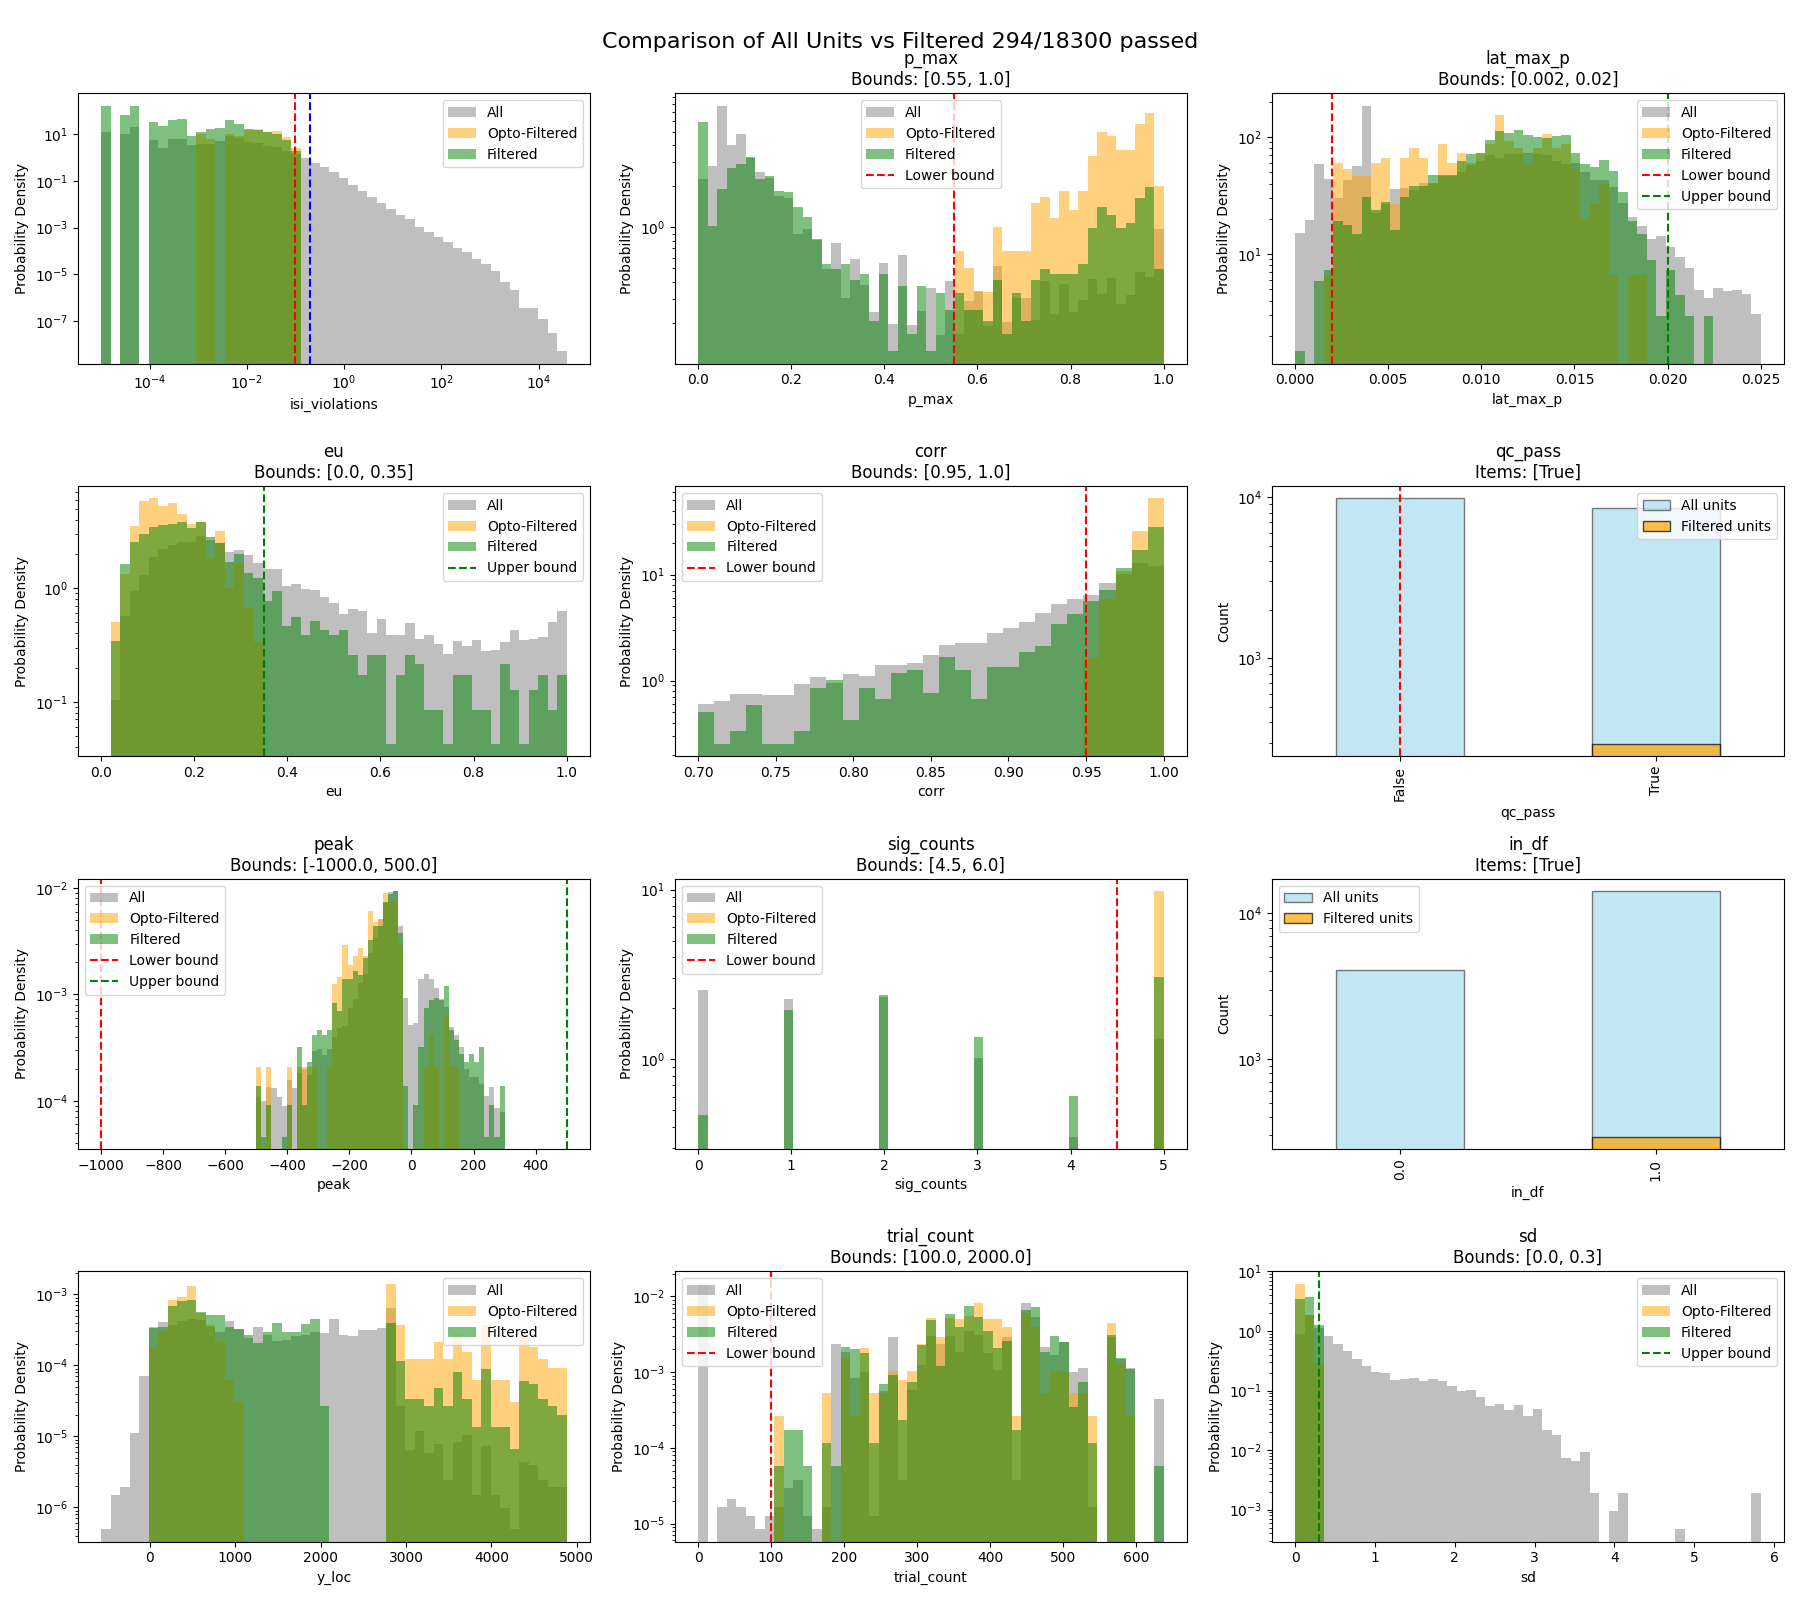

In [126]:
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
if 'tier_2' not in combined_tagged_units.columns:
    combined_tagged_units['tier_2'] = False
combined_tagged_units_filtered, combined_tagged_units, fig, axes = apply_qc(combined_tagged_units, constraints)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
combined_tagged_units_filtered.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units_filtered['unit_id'] = combined_tagged_units_filtered['unit_id'].apply(to_str_intlike)


In [127]:
# load and add model variables
model_combined = pd.read_csv(os.path.join(beh_folder, 'figures_in_generation', f'model_combined_{criteria_name}.csv'), index_col=0)
model_combined['theta'] = model_combined['theta'] - 0.5
model_combined['unit_id'] = model_combined['unit_id'].apply(to_str_intlike)

versions = ['e', 'l', 'com']
for version in versions:
    all_vec = np.column_stack((
        model_combined[f'coef_outcome_{version}_mc'],
        model_combined[f'coef_Qchosen_{version}_ori']
    ))
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
    bound_1, bound_2, bound_3 = -(1 / 4) * np.pi, np.pi, -np.pi
    theta_scaled_dis = np.zeros_like(theta)
    for ind, angle_curr in enumerate(theta):
        if bound_1 < angle_curr <= bound_2:
            theta_scaled_dis[ind] = (angle_curr - bound_1) / (bound_2 - bound_1)
        else:
            theta_scaled_dis[ind] = (bound_1 - angle_curr) / (bound_1 - bound_3)
    theta_scaled_dis_all = 1 - theta_scaled_dis - 0.5
    model_combined[f'theta_{version}'] = theta_scaled_dis_all

# derived features
model_combined['coef_outcome|(|coef_outcome| + |coef_Q|)'] = (
    model_combined['coef_outcome_com_mc'] /
    (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
)
model_combined['outcome_ipsi'] = (
    model_combined['coef_outcome_com_mc'] + model_combined['coef_outcome:ipsi_com_mc']
)
model_combined['outcome_contra'] = (
    model_combined['coef_outcome_com_mc'] - model_combined['coef_outcome:ipsi_com_mc']
)
# model_combined = model_combined.merge(combined_tagged_units_beh[['session', 'unit_id', 'selected']], on=['session', 'unit_id'], how='left')
# model_combined = model_combined[model_combined['selected']]

In [128]:
pupil_df.rename(columns={'unit': 'unit_id'}, inplace=True)

In [129]:
# Combine all features
features_combined = pupil_df.merge(model_combined, on=['session', 'unit_id'], suffixes=('', '_pupil'), how='left')
features_combined = pd.merge(features_combined, wf_features, on=['session', 'unit_id'], suffixes=('', '_wf'), how='left')
features_combined = pd.merge(features_combined, basic_ephys_df, on=['session', 'unit_id'], suffixes=('', '_be'), how='left')
response_tbl = pd.read_csv(f'/root/capsule/scratch/combined/beh_plots/beh_all/response_ratio_beh_all_go_cue.csv')
response_tbl['unit_id'] = response_tbl['unit'].apply(to_str_intlike)
features_combined = features_combined.merge(response_tbl, on=['session', 'unit_id'], how='left')

# features_combined = features_combined.merge(antidromic_df, on=['session', 'unit_id'], how='outer')
features_combined = features_combined.merge(combined_tagged_units_filtered[['session', 'unit_id', 'probe', 'x_ccf', 'y_ccf', 'z_ccf', 'isi_violations', 'y_loc', 'sd']], on=['session', 'unit_id'], how='inner')
features_combined['be_filter'] = (features_combined['be_filter'].fillna(False).astype(bool))
features_combined['be_filter'] = features_combined['be_filter'] & (features_combined['error_prop']<=0.25)

/tmp/ipykernel_28023/2563854748.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_combined['be_filter'] = (features_combined['be_filter'].fillna(False).astype(bool))


In [130]:
behavior_file = '/root/capsule/scratch/combined/combined_session_tbl/combined_beh_sessions.pkl'
with open(behavior_file, 'rb') as f:
    combined_beh_sessions = pickle.load(f)
features_combined = features_combined.merge(combined_beh_sessions, on='session', how='left')

In [131]:
# pull all pupil data into one folder
data_df = pd.read_csv('/root/capsule/code/data_management/hopkins_session_assets.csv')
sessions = data_df['session_id'].values.tolist()
target_folder = os.path.join(pupil_folder, 'all_sessions')
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
for session in sessions:
    session_dir = session_dirs(session)
    pupil_file = os.path.join(session_dir['beh_fig_dir'], f'{session}_pupil_analysis.pdf')
    if os.path.exists(pupil_file):
        dest_file = os.path.join(target_folder, f'{session}_pupil_analysis.pdf')
        shutil.copyfile(pupil_file, dest_file)

No raw session directory found for behavior_ZS059_2021-04-18_17-26-19.
No raw session directory found for behavior_ZS060_2021-04-10_16-58-41.
No raw session directory found for behavior_ZS060_2021-04-11_16-41-30.
No raw session directory found for behavior_ZS060_2021-04-12_15-57-59.
No raw session directory found for behavior_ZS060_2021-04-14_18-15-27.
No raw session directory found for behavior_ZS060_2021-04-21_19-23-52.
No raw session directory found for behavior_ZS060_2021-04-27_16-21-43.
No raw session directory found for behavior_ZS061_2021-04-03_18-50-29.
No raw session directory found for behavior_ZS062_2021-03-30_18-30-24.


In [42]:
combine_pdf_big(target_folder, os.path.join(pupil_folder, f'all_sessions_pupil_analysis_{criteria_name}.pdf'))

Processing 139 files in /root/capsule/scratch/combined/pupil_plots/beh_all/all_sessions
Combined PDF saved as: /root/capsule/scratch/combined/pupil_plots/beh_all/all_sessions_pupil_analysis_beh_all.pdf


# Compare between features

In [79]:
cross_list = features_combined['crosscorr_with_trials']
cross_list_no_trial = features_combined['crosscorr_no_trials']
valid_mask = features_combined['crosscorr_with_trials'].isna() == False
valid_mask = valid_mask & (features_combined['be_filter'].values)
valid_idx = np.where(valid_mask)[0]
m = len(cross_list[valid_idx[0]])

cross_mat = np.full((len(cross_list), m), np.nan)
cross_mat_no_trial = np.full((len(cross_list), m), np.nan)
for i in valid_idx:
    cross_mat[i] = np.array(cross_list[i]) - cross_list[i][0]
    cross_mat_no_trial[i] = np.array(cross_list_no_trial[i]) - cross_list_no_trial[i][0]
lag_time = features_combined['crosscorr_lags'].values[valid_idx[0]]

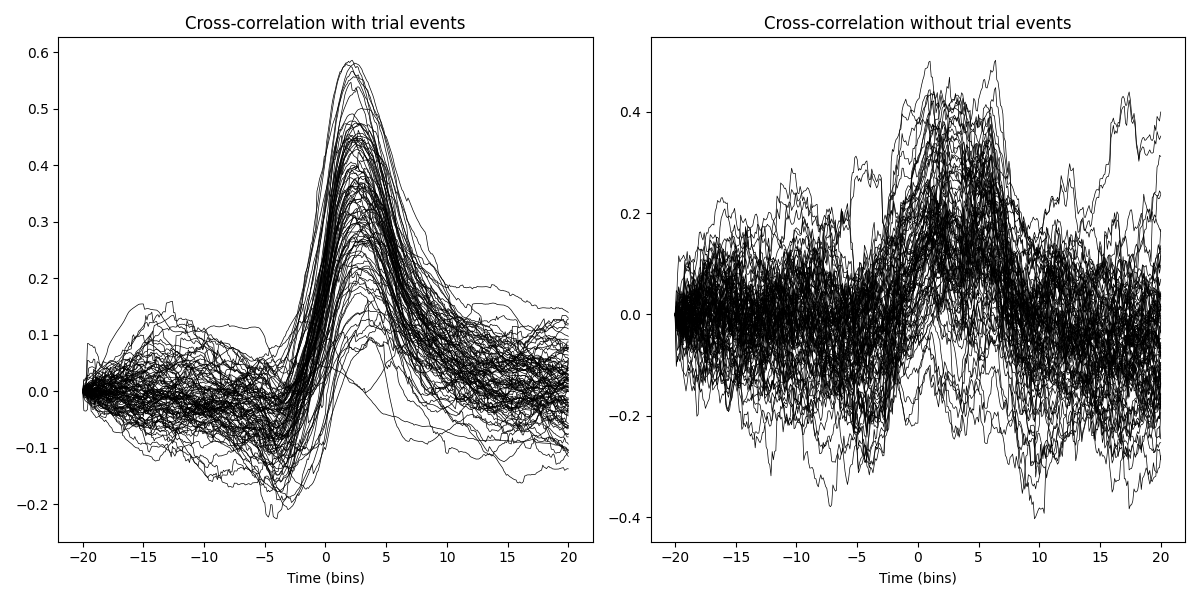

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
im = axes[0].plot(lag_time, cross_mat.T, color='k', linewidth=0.5)
axes[0].set_title('Cross-correlation with trial events')
axes[0].set_xlabel('Time (bins)')

im = axes[1].plot(lag_time, cross_mat_no_trial.T, color='k', linewidth=0.5)
axes[1].set_title('Cross-correlation without trial events')
axes[1].set_xlabel('Time (bins)')
plt.tight_layout()
plt.savefig(os.path.join(pupil_folder, f'crosscorrelation_all_units_{criteria_name}.pdf'))
plt.savefig(os.path.join(pupil_folder, f'crosscorrelation_all_units_{criteria_name}.svg'))

In [81]:
# find peak time and value for each unit
peak_lag = np.full(len(cross_list), np.nan)
peak_value = np.full(len(cross_list), np.nan)
for i in valid_idx:
    cross_curr = cross_mat[i]
    peak_idx = np.argmax(cross_curr)
    peak_lag[i] = lag_time[peak_idx]
    peak_value[i] = cross_curr[peak_idx]
features_combined['peak_lag'] = peak_lag
features_combined['peak_value'] = peak_value


# do same for no trial
peak_lag_no_trial = np.full(len(cross_list_no_trial), np.nan)
peak_value_no_trial = np.full(len(cross_list_no_trial), np.nan)
for i in valid_idx:
    cross_curr = cross_mat_no_trial[i]
    peak_idx = np.argmax(cross_curr)
    peak_lag_no_trial[i] = lag_time[peak_idx]
    peak_value_no_trial[i] = cross_curr[peak_idx]
features_combined['peak_lag_no_trial'] = peak_lag_no_trial
features_combined['peak_value_no_trial'] = peak_value_no_trial

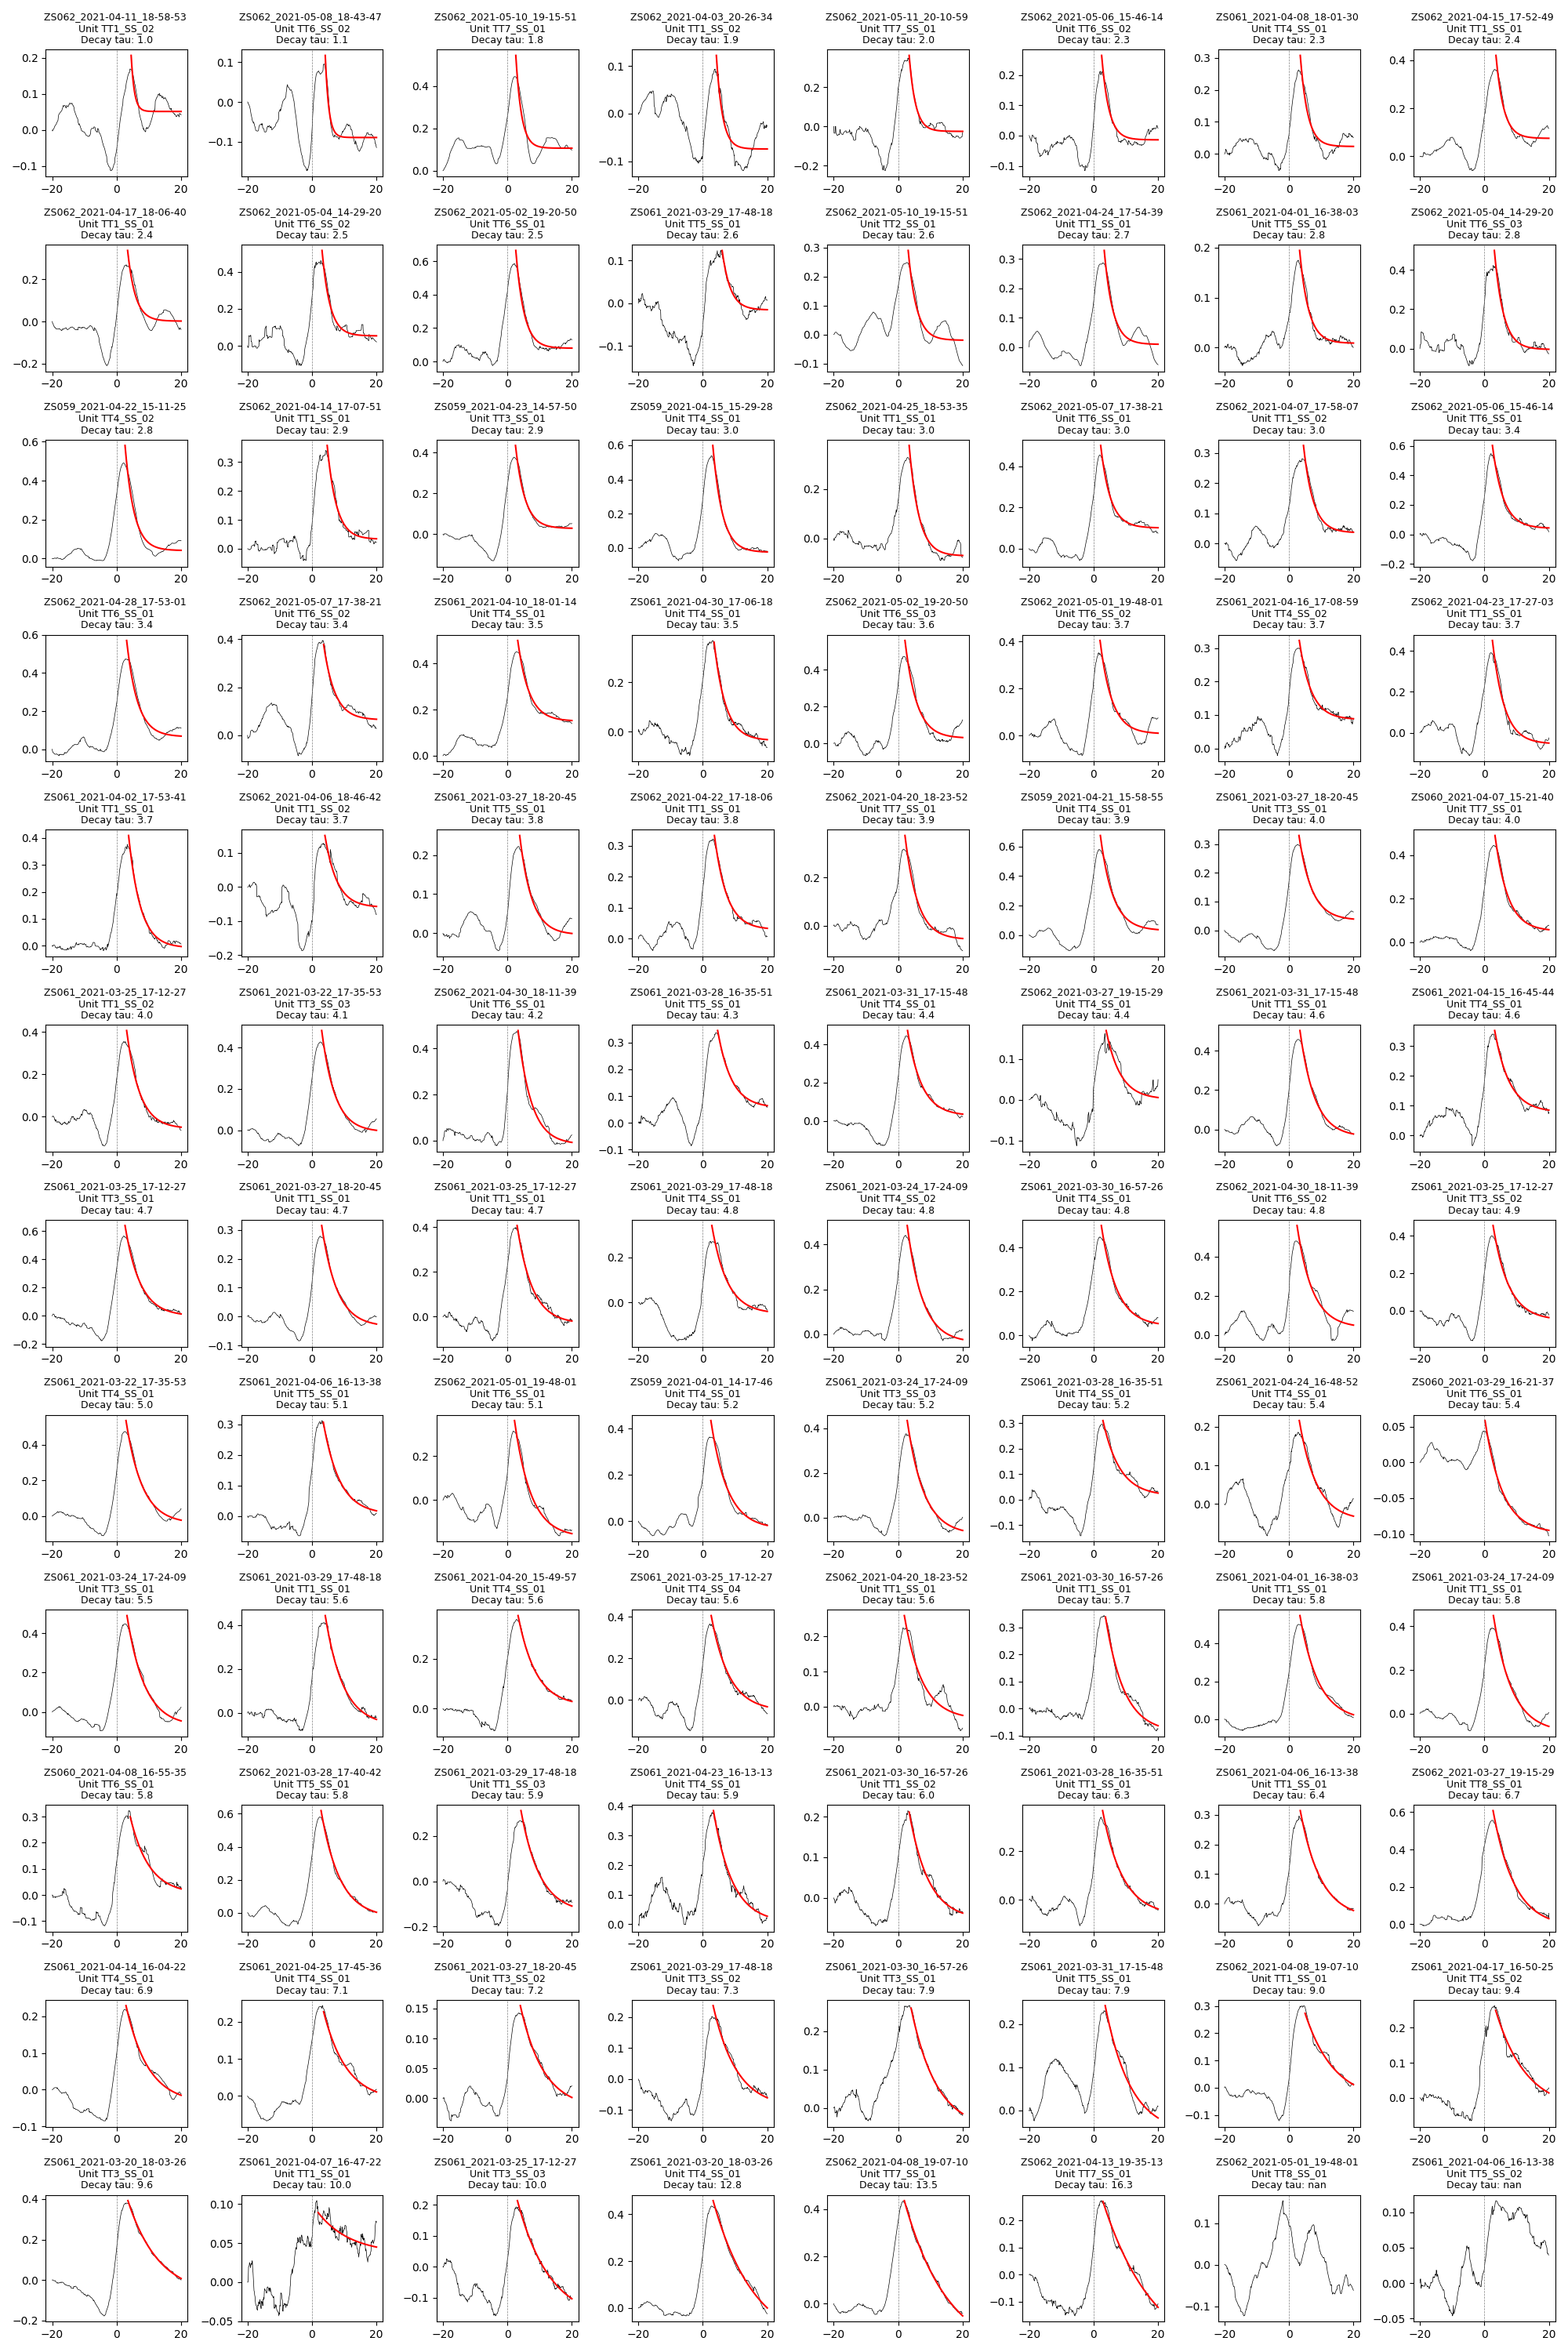

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Fit exponential decay to post-peak period: y = A * exp(-t/tau) + C
def exp_decay(x, A, tau, C):
    return A * np.exp(-x / tau) + C

n = len(cross_list)
decay_tau = np.full(n, np.nan)

# store fitted curves aligned to cross_mat rows (NaN when not available)
cross_mat_fitted = np.full_like(cross_mat, np.nan, dtype=float)

# store peak indices (optional, but handy for plotting)
peak_idx_arr = np.full(n, -1, dtype=int)

for i in valid_idx:
    cross_curr = np.asarray(cross_mat[i], dtype=float)

    if cross_curr.size == 0 or not np.any(np.isfinite(cross_curr)):
        continue

    peak_idx = int(np.nanargmax(cross_curr))
    peak_idx_arr[i] = peak_idx

    start = peak_idx + 4
    if start >= len(lag_time) or start >= len(cross_curr):
        continue  # no post-peak region

    post_peak_time = np.asarray(lag_time[start:], dtype=float)
    post_peak_values = np.asarray(cross_curr[start:], dtype=float)

    mask = np.isfinite(post_peak_time) & np.isfinite(post_peak_values)
    x = post_peak_time[mask]
    y = post_peak_values[mask]

    if x.size < 3:
        continue  # not enough points to fit

    # initial guess
    A0 = y[0] - y[-1]
    tau0 = 100.0
    C0 = y[-1]
    p0 = (A0, tau0, C0)

    # bounds: tau must be positive; allow A to be +/-; C free
    bounds = ([-np.inf, 1e-6, -np.inf], [np.inf, np.inf, np.inf])

    try:
        popt, _ = curve_fit(exp_decay, x, y, p0=p0, bounds=bounds, maxfev=20000)
        decay_tau[i] = popt[1]
        if np.abs(decay_tau[i]) > 1000:
            decay_tau[i] = np.nan

        # generate fitted curve on the full post-peak time vector (not just masked points)
        fit_full = exp_decay(post_peak_time, *popt)
        cross_mat_fitted[i, start:start + fit_full.size] = fit_full

    except Exception:
        continue

# --- visualize fits ---
valid_tau = decay_tau[valid_idx]
sorted_local = np.argsort(valid_tau)  # indices within valid_idx (NaNs go last if any)

n_units = len(valid_idx)
n_cols = 8
n_rows = int(np.ceil(n_units / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 2.5 * n_rows))
axes = np.atleast_1d(axes).ravel()

for plot_idx, local in enumerate(sorted_local):
    i = valid_idx[local]
    ax = axes[plot_idx]

    cross_curr = cross_mat[i]
    ax.plot(lag_time, cross_curr, color='k', linewidth=0.5)

    # overlay fitted curve where available
    if np.isfinite(decay_tau[i]):
        ax.plot(lag_time, cross_mat_fitted[i], color='r', linewidth=1.5)

    unit_id = features_combined["unit_id"].values[i] if "unit_id" in features_combined.columns else i
    session = features_combined["session"].values[i] if "session" in features_combined.columns else 'N/A'
    ax.set_title(f'{session[9:]} \nUnit {unit_id}\nDecay tau: {decay_tau[i]:.1f}', fontsize=9)
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

# turn off unused axes
for k in range(n_units, n_rows * n_cols):
    axes[k].axis("off")

plt.tight_layout()


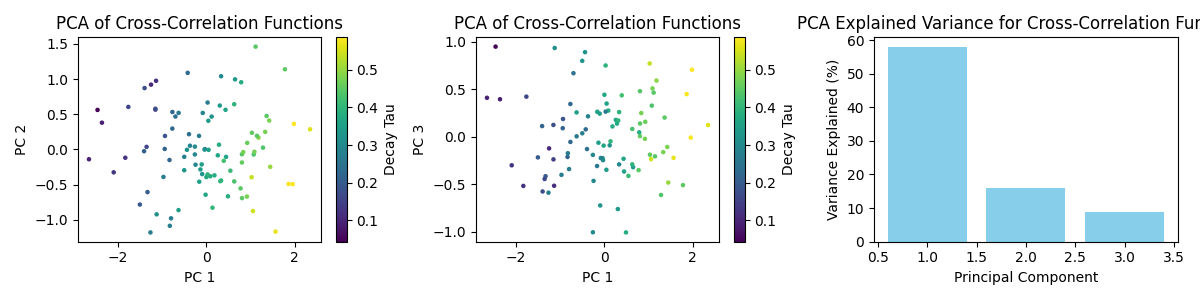

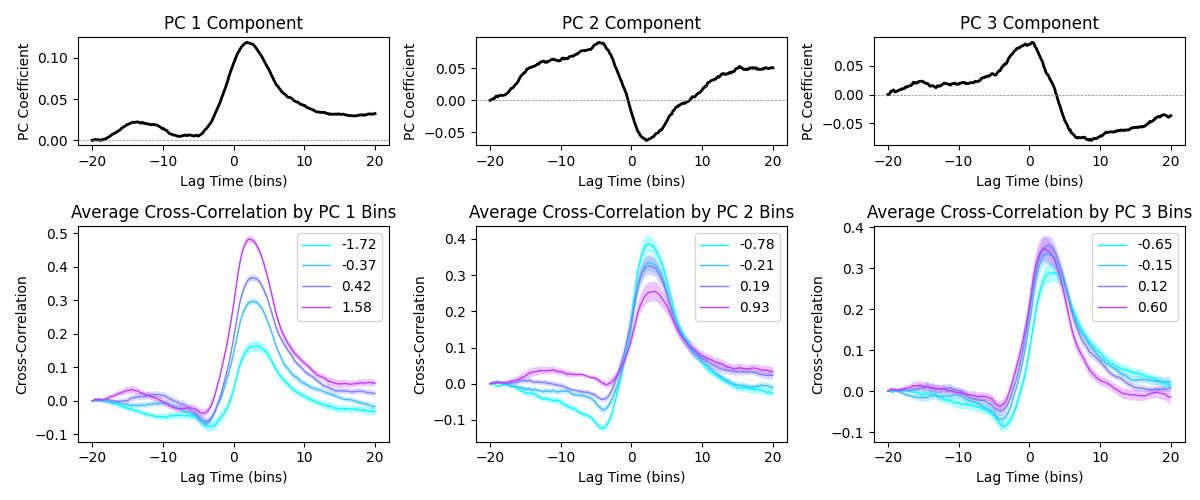

In [83]:
# pcs on crosscorr
from sklearn.decomposition import PCA
from scipy.stats import zscore
valid_cross = cross_mat[valid_idx]
# valid_cross = zscore(valid_cross, axis=1, nan_policy='omit')
pca = PCA(n_components=3)
pca.fit(valid_cross)
pcs = pca.transform(valid_cross)
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(131)
sc = ax.scatter(pcs[:, 0], pcs[:, 1], c=peak_value[valid_idx], cmap='viridis', s=5)
plt.colorbar(sc, ax=ax, label='Decay Tau')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('PCA of Cross-Correlation Functions')
ax = fig.add_subplot(132)
sc = ax.scatter(pcs[:, 0], pcs[:, 2], c=peak_value[valid_idx], cmap='viridis', s=5)
plt.colorbar(sc, ax=ax, label='Decay Tau')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 3')
ax.set_title('PCA of Cross-Correlation Functions')
plt.tight_layout()


# exmplain power
explained_variance = pca.explained_variance_ratio_ * 100  # percentage
ax = fig.add_subplot(133)
ax.bar(range(1, len(explained_variance) + 1), explained_variance, color='skyblue')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained (%)')
ax.set_title('PCA Explained Variance for Cross-Correlation Functions')
plt.tight_layout()


# bin cross_corr by pc1 - pc3 and plot average crosscorr
pc_bins = 4
fig, axes = plt.subplots(2, 3, figsize=(12, 5), height_ratios=[0.5, 1])
for pc_idx in range(3):
    pc_values = pcs[:, pc_idx]
    bin_edges = np.percentile(pc_values, np.linspace(0, 100, pc_bins + 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # plot pc coeficients
    axes[0, pc_idx].plot(lag_time, pca.components_[pc_idx], color='k', linewidth=2)
    axes[0, pc_idx].set_title(f'PC {pc_idx + 1} Component')
    axes[0, pc_idx].set_xlabel('Lag Time (bins)')
    axes[0, pc_idx].set_ylabel('PC Coefficient')
    axes[0, pc_idx].axhline(0, color='gray', linestyle='--', linewidth=0.5)
    for b in range(pc_bins):
        bin_mask = (pc_values >= bin_edges[b]) & (pc_values < bin_edges[b + 1])
        if np.sum(bin_mask) == 0:
            continue
        mean_crosscorr = np.nanmean(valid_cross[bin_mask], axis=0)
        sem_crosscorr = np.nanstd(valid_cross[bin_mask], axis=0) / np.sqrt(np.sum(bin_mask))
        axes[1, pc_idx].plot(lag_time, mean_crosscorr, label=f'{bin_centers[b]:.2f}', color = colormaps['cool'](b / pc_bins), linewidth=1)
        axes[1, pc_idx].fill_between(lag_time, mean_crosscorr - sem_crosscorr, mean_crosscorr + sem_crosscorr, alpha=0.3, facecolor=colormaps['cool'](b / pc_bins))


    axes[1, pc_idx].set_title(f'Average Cross-Correlation by PC {pc_idx + 1} Bins')
    axes[1, pc_idx].set_xlabel('Lag Time (bins)')
    axes[1, pc_idx].set_ylabel('Cross-Correlation')
    axes[1, pc_idx].legend()
plt.tight_layout()

features_combined['decay_tau_cross'] = decay_tau
features_combined.loc[:, 'cross_pc_1'] = np.nan
features_combined.loc[:, 'cross_pc_2'] = np.nan
features_combined.loc[valid_idx, 'cross_pc_1'] = pcs[:, 0]
features_combined.loc[valid_idx, 'cross_pc_2'] = pcs[:, 1]



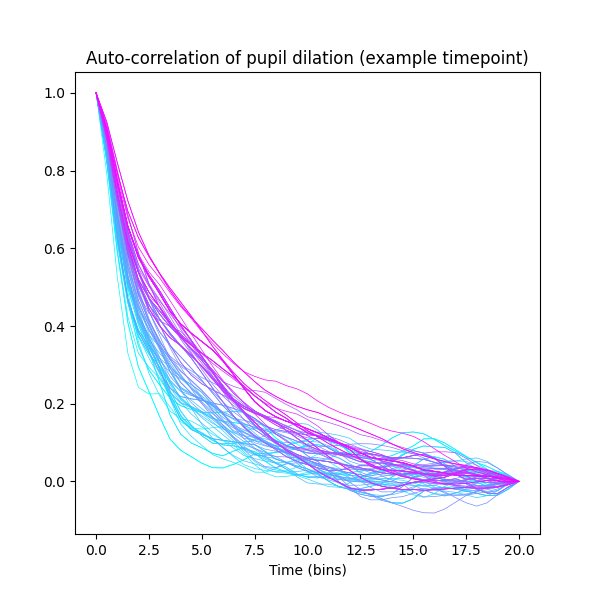

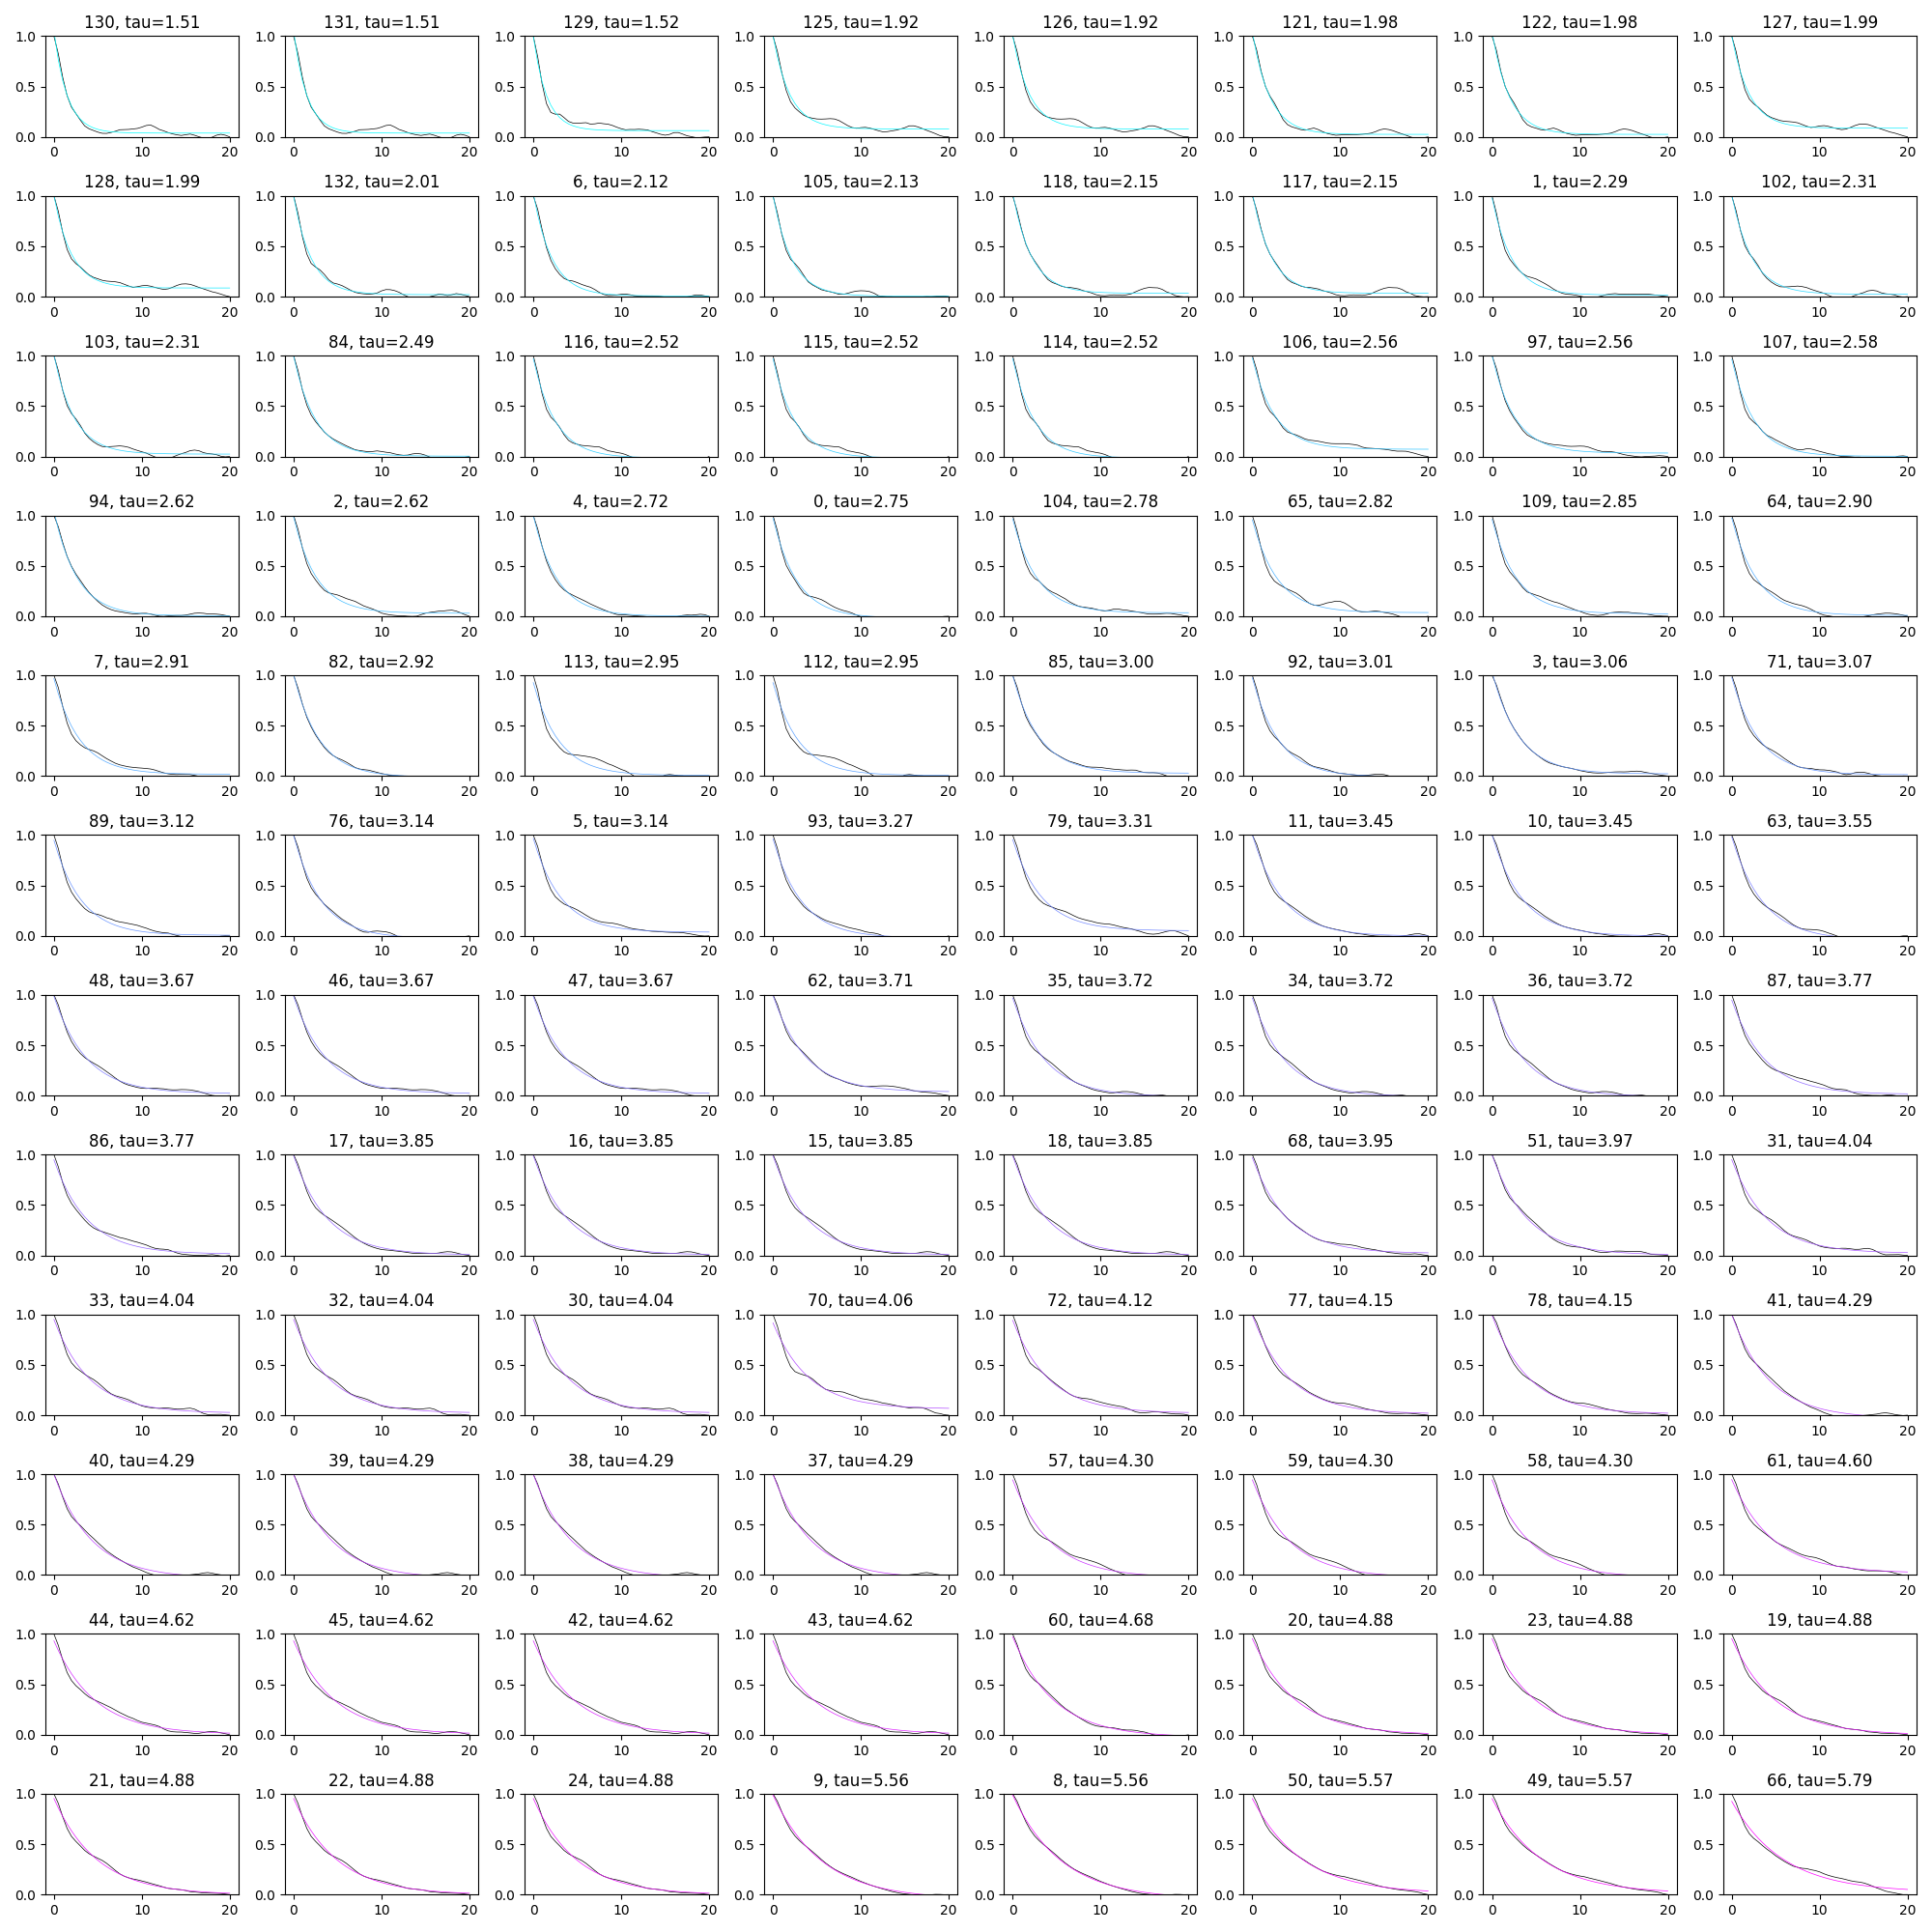

In [84]:
# auto-corr structure
auto_list = features_combined['auto_corr_pupil_with_trials']
valid_mask_auto = features_combined['auto_corr_pupil_with_trials'].isna() == False
valid_mask_auto = valid_mask_auto & (features_combined['be_filter'].values)
valid_idx_auto = np.where(valid_mask_auto)[0]
m_auto = len(auto_list[valid_idx_auto[0]])
auto_mat = np.full((len(auto_list), m_auto), np.nan)
for i in valid_idx_auto:
    auto_mat[i] = (np.array(auto_list[i]) - auto_list[i][-1])/(1-auto_list[i][-1])  # normalize to 0 at lag 0
lag_time_auto = features_combined['auto_corr_pupil_lags'].values[valid_idx_auto[0]]

# fit exponential decay to auto-corr
# y = A * exp(-x/tau) + C
decay_tau = np.full(len(auto_list), np.nan)


auto_mat_fitted = np.full_like(auto_mat, np.nan)
for i in valid_idx_auto:
    auto_curr = auto_mat[i]
    # find peaks
    decay_x = lag_time_auto
    decay_y = auto_curr
    # fit exponential decay
    # initial guess
    A0 = decay_y[0] - decay_y[-1]
    tau0 = 10
    C0 = decay_y[-1]
    p0 = [A0, tau0, C0]
    bounds = ([0, 0, -np.inf], [np.inf, np.inf, np.inf])
    popt, pcov = curve_fit(exp_decay, decay_x, decay_y, p0=p0, bounds=bounds)
    decay_tau[i] = popt[1]

    auto_mat_fitted[i] = exp_decay(decay_x, *popt)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# plot by sorted decay tau use color map cool
sorted_idx = np.argsort(decay_tau[valid_idx_auto])

cmap = plt.get_cmap('cool')
for rank, idx in enumerate(sorted_idx):
    unit_idx = valid_idx_auto[idx]
    color = cmap(rank / len(sorted_idx))
    ax.plot(lag_time_auto, auto_mat[unit_idx], color=color, linewidth=0.5)
ax.set_title('Auto-correlation of pupil dilation (example timepoint)')
ax.set_xlabel('Time (bins)')


# plot fitted curves one by one, 8 in a row
fig, axes = plt.subplots(int(np.ceil(len(sorted_idx)/8)), 8, figsize=(20, 20))

for rank, idx in enumerate(sorted_idx):
    unit_idx = valid_idx_auto[idx]
    row = rank // 8
    col = rank % 8
    ax = axes[row, col]
    ax.plot(lag_time_auto, auto_mat[unit_idx], color='k', linewidth=0.5)
    ax.plot(lag_time_auto, auto_mat_fitted[unit_idx], color=cmap(rank / len(sorted_idx)), linewidth=0.5)
    ax.set_ylim([0, 1])
    ax.set_title(f'{unit_idx}, tau={decay_tau[unit_idx]:.2f}')
plt.tight_layout()

features_combined['decay_tau'] = decay_tau
# decay_tau_bl_remove = decay_tau.copy()
fig.savefig(fname = os.path.join(pupil_folder, 'all_decay.pdf'))

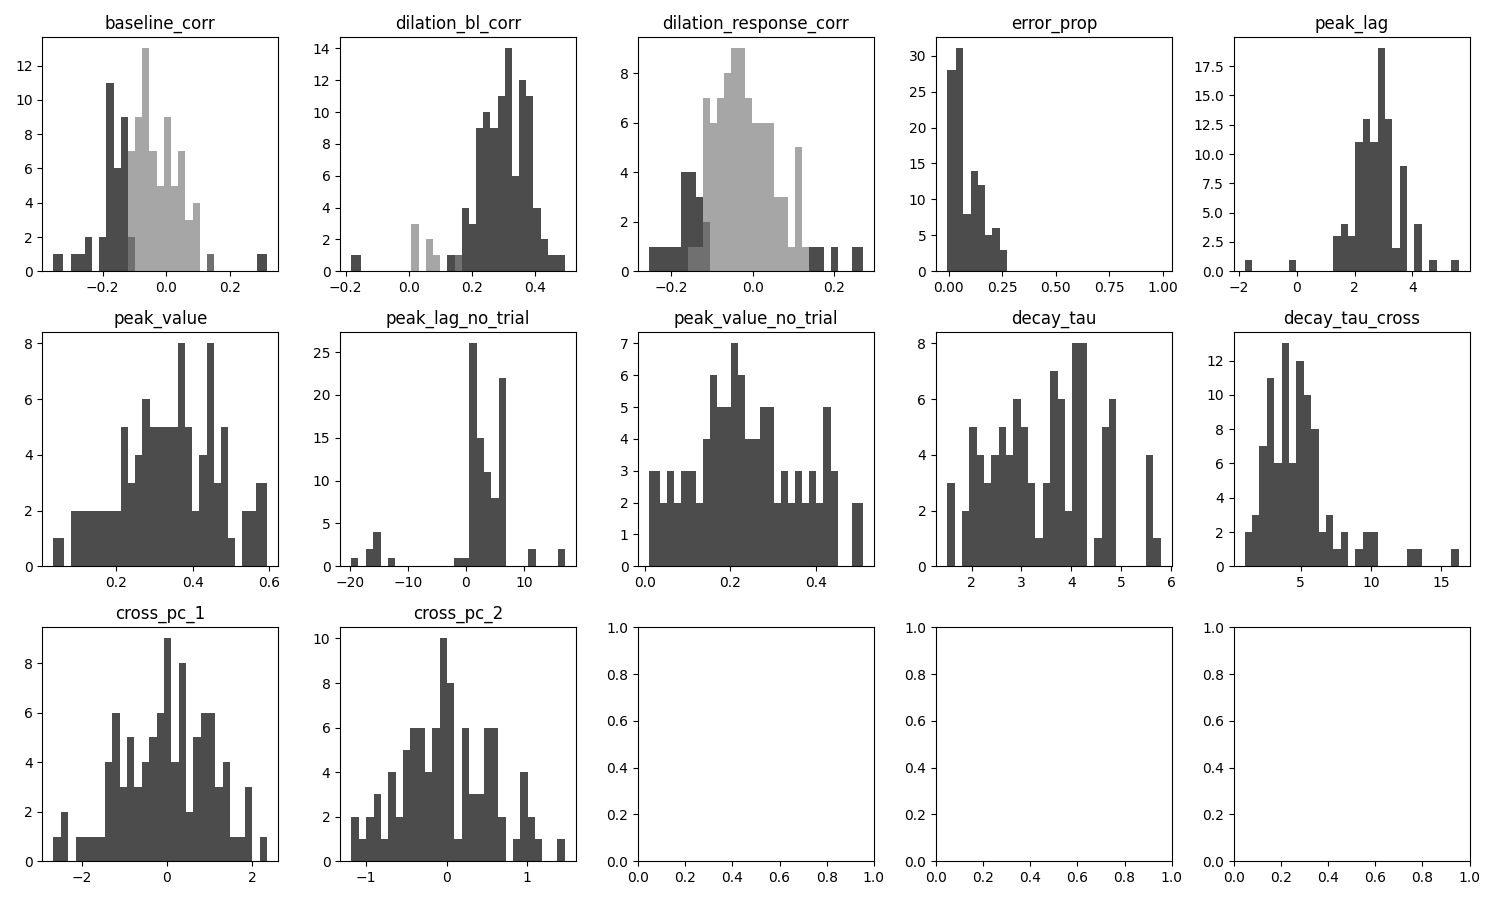

In [85]:
col_to_hist = ['baseline_corr', 'dilation_bl_corr', 'dilation_response_corr', 'error_prop', 'peak_lag', 'peak_value', 'peak_lag_no_trial', 'peak_value_no_trial','decay_tau', 'decay_tau_cross', 'cross_pc_1', 'cross_pc_2']
fig, axes = plt.subplots(int(np.ceil(len(col_to_hist)/5)), 5, figsize=(3 * 5, 3 * int(np.ceil(len(col_to_hist)/5))))
mask = features_combined['error_prop'] <= 0.25
for i, col in enumerate(col_to_hist):
    mask_col = col.split('_corr')[0] + '_p_sig'
    edges = np.linspace(np.nanmin(features_combined[col].dropna().values), np.nanmax(features_combined[col].dropna().values), 30)
    edges[-1] += 0.01
    edges[0] -= 0.01
    row = i // 5
    col_idx = i % 5
    ax = axes[row, col_idx]
    if mask_col in features_combined.columns:
        sig_mask = features_combined[mask_col] < 0.05
        ax.hist(features_combined.loc[sig_mask&mask, col].dropna(), bins=edges, alpha=0.7, label='p < 0.05', facecolor = 'k')
        ax.hist(features_combined.loc[~sig_mask&mask, col].dropna(), bins=edges, alpha=0.7, label='p >= 0.05', facecolor = 'gray')
    else:
        ax.hist(features_combined.loc[mask, col].dropna(), bins=edges, facecolor = 'k', alpha=0.7)
    ax.set_title(col)
plt.tight_layout()
plt.savefig(os.path.join(pupil_folder, f'pupil_ephys_summary_histograms_{criteria_name}.pdf'))
plt.savefig(os.path.join(pupil_folder, f'pupil_ephys_summary_histograms_{criteria_name}.svg'))

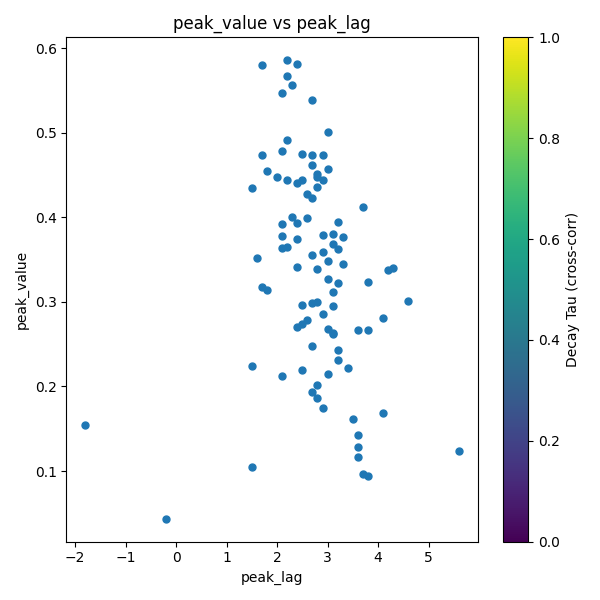

In [22]:
x_value = 'peak_lag'
y_value = 'peak_value'
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
mask = features_combined['error_prop'] <= 0.25
sc = ax.scatter(features_combined.loc[mask, x_value], features_combined.loc[mask, y_value], s=25)
plt.colorbar(sc, ax=ax, label='Decay Tau (cross-corr)')
ax.set_xlabel(x_value)
ax.set_ylabel(y_value)
ax.set_title(f'{y_value} vs {x_value}')
plt.tight_layout()
fig.savefig(os.path.join(pupil_folder, f'{y_value}_vs_{x_value}_col_decay_tau_cross_{criteria_name}.pdf'))
fig.savefig(os.path.join(pupil_folder, f'{y_value}_vs_{x_value}_col_decay_tau_cross_{criteria_name}.svg'))

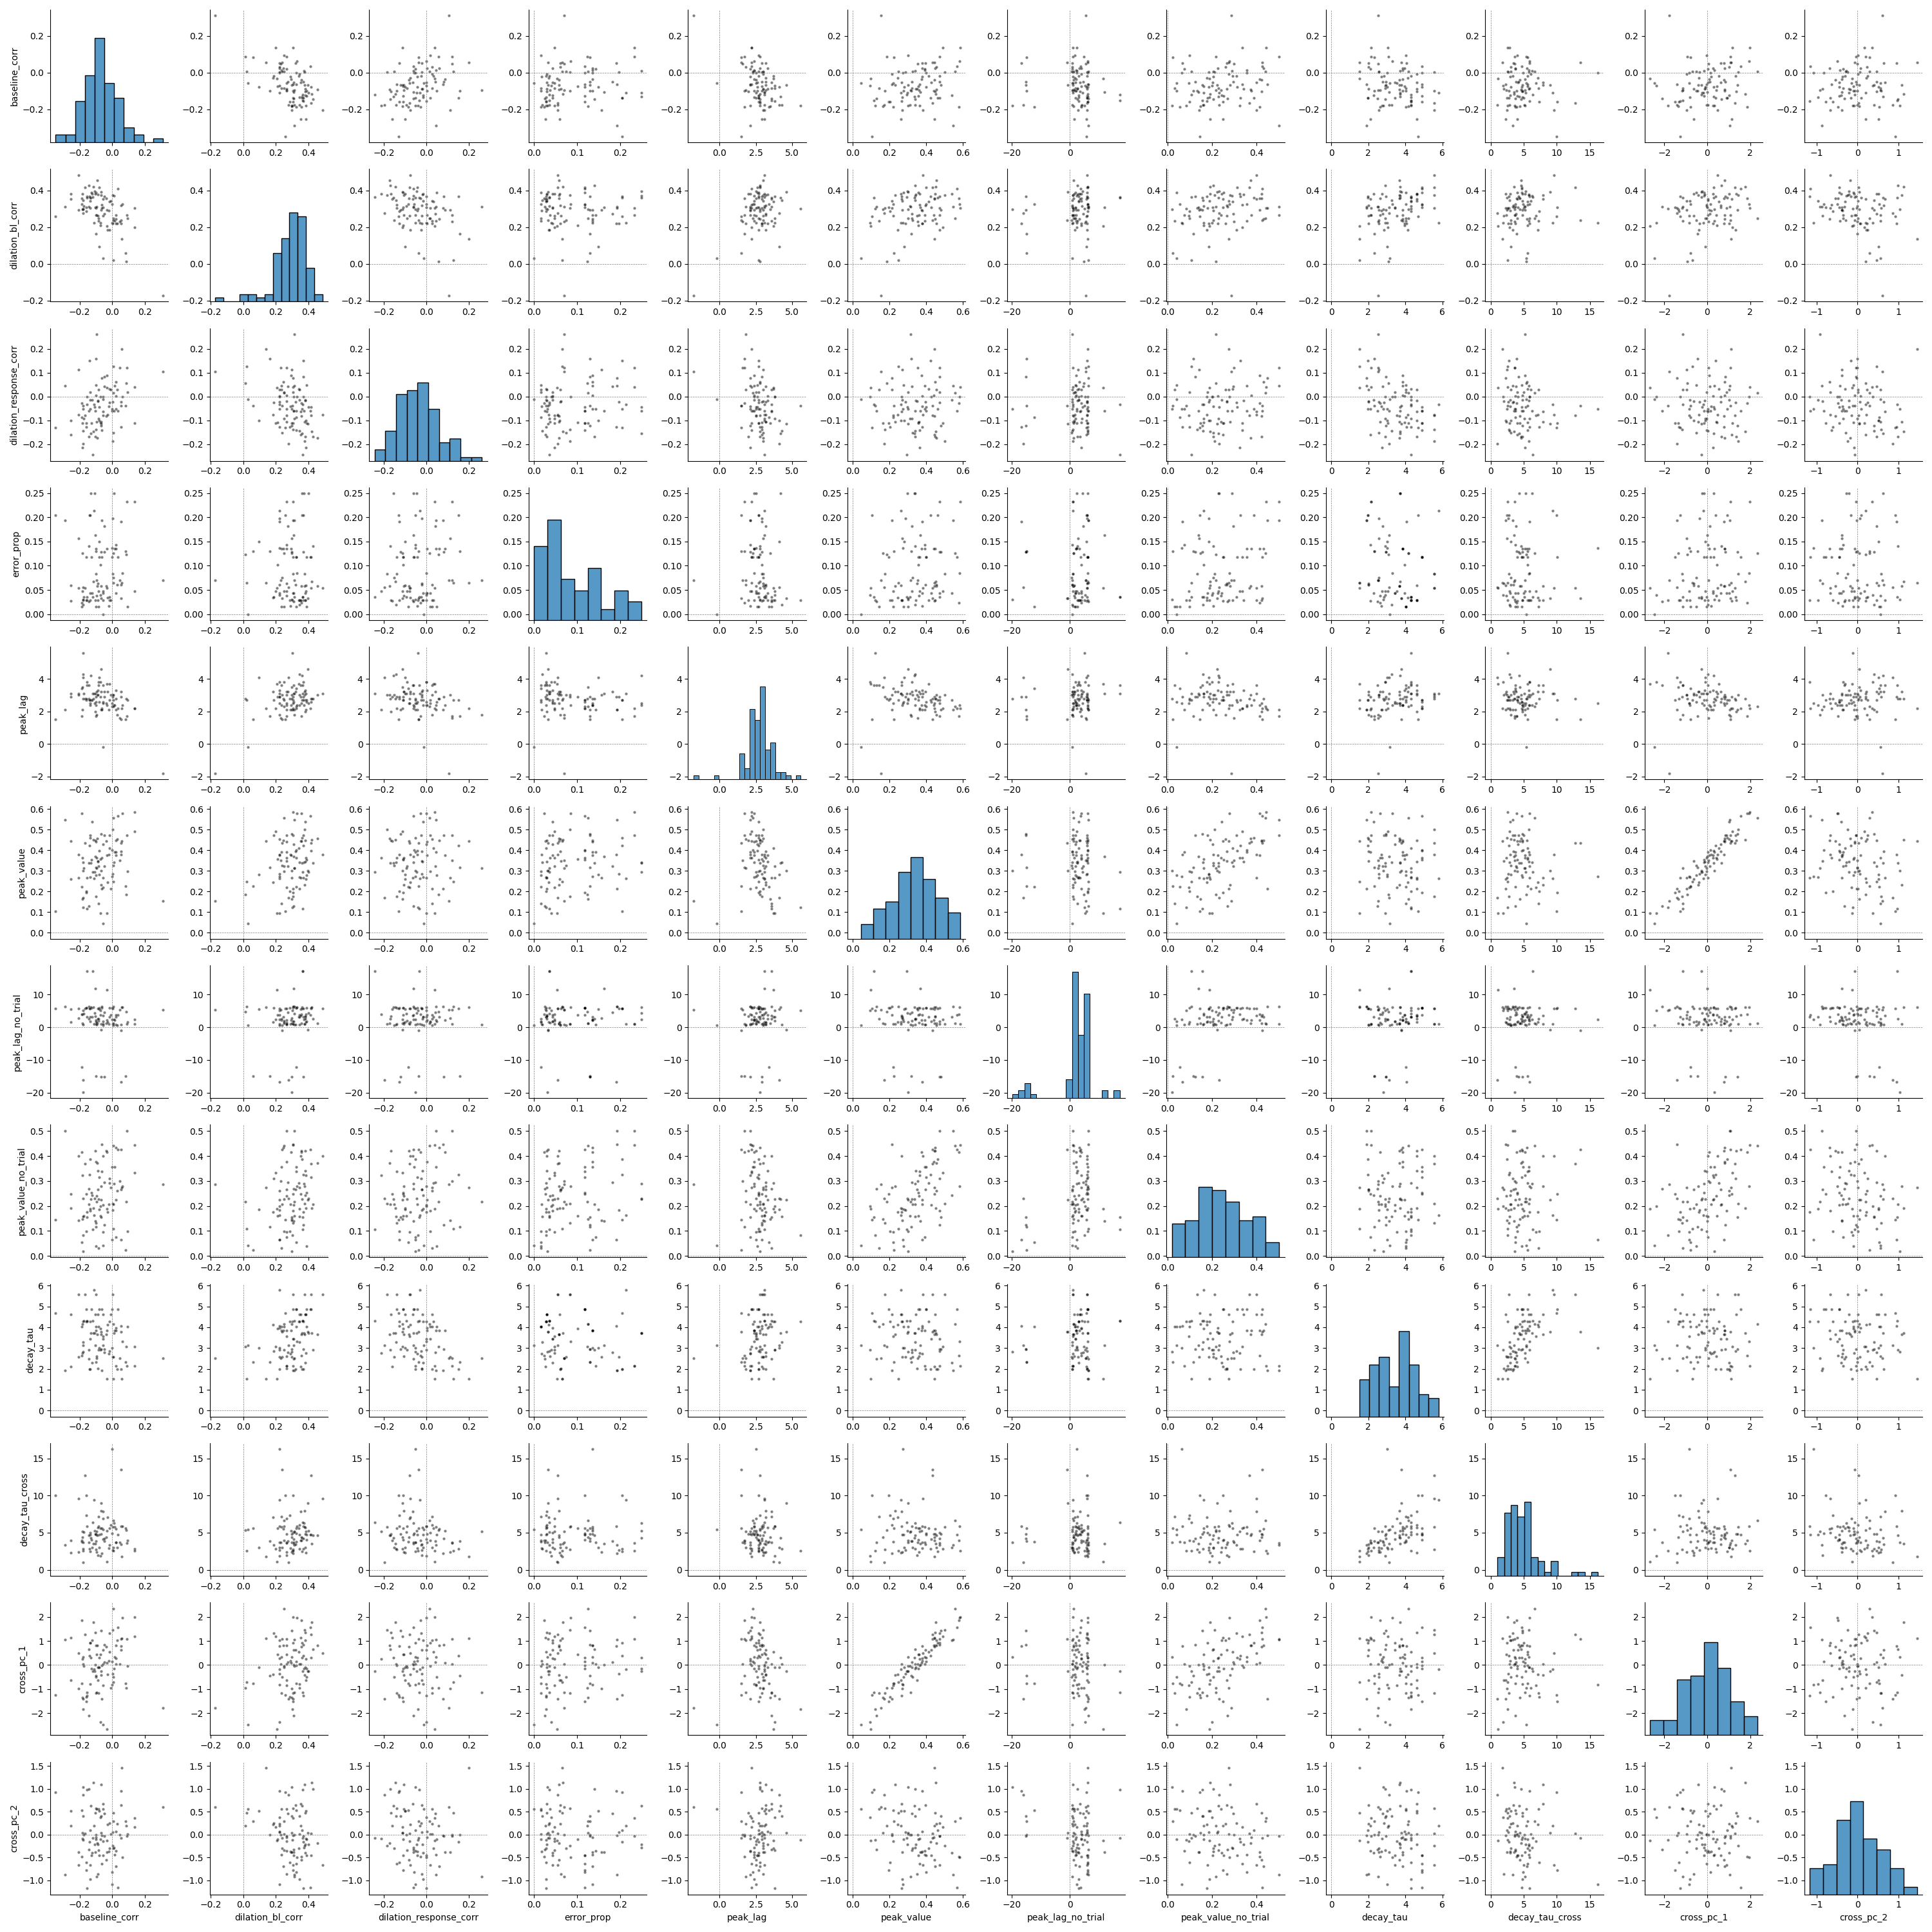

In [45]:
g =  sns.pairplot(features_combined[features_combined['be_filter']][col_to_hist], vars=col_to_hist, diag_kind='hist', plot_kws={'alpha':0.5, 's':10, 'color':'k'})
# add axis to each subplot
n = len(col_to_hist)

for i in range(n):
    for j in range(n):
        ax = g.axes[i, j]

        # reference lines
        if i != j:
            ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
            ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)

        # force labels on EVERY axis
        ax.set_xlabel(col_to_hist[j])
        ax.set_ylabel(col_to_hist[i])

        # re-enable tick labels (seaborn disables inner ones)
        ax.tick_params(
            labelbottom=True,
            labelleft=True
        )

g.fig.tight_layout()

In [51]:
g.savefig(os.path.join(pupil_folder, 'pupil_ephys_feature_pairwise_correlation.png'))
g.savefig(os.path.join(pupil_folder, 'pupil_ephys_feature_pairwise_correlation.pdf'))

# Compare with behavior

In [132]:
pupil_features_to_check = ['baseline_corr', 'dilation_bl_corr', 'dilation_response_corr', 'peak_lag', 'peak_value', 'decay_tau', 'cross_pc_1', 'cross_pc_2']

In [141]:
pupil_model_params_to_check = pupil_fit_df.columns.tolist()
pupil_model_params_to_check.remove('session')

In [142]:
pupil_model_params_to_check

['choice_resp_outcome',
 'choice_resp_outcome_min_p',
 'choice_resp_svs',
 'choice_resp_svs_min_p',
 'choice_resp_choice',
 'choice_resp_choice_min_p',
 'choice_resp_choice:outcome',
 'choice_resp_choice:outcome_min_p',
 'choice_bl_svs',
 'choice_bl_svs_min_p',
 'all_resp_hit',
 'all_resp_hit_min_p',
 'all_bl_hit',
 'all_bl_hit_min_p']

In [136]:
beh_cols = combined_beh_sessions.columns
beh_cols = beh_cols.to_list()
remove_cols = ['coeff_reward', 'ci-bands_reward','coeff_no-reward','ci-bands_no-reward','session','reward','model_name','session_id','probe','lick_bias', 'animal_id', 'model_name', 'ani_id']
for col in remove_cols:
    if col in beh_cols:
        beh_cols.remove(col)

In [ ]:
fig, axes = plt.subplots(
    len(beh_cols),
    len(pupil_features_to_check),
    figsize=(3 * len(pupil_features_to_check), 3 * len(beh_cols)),
    squeeze=False
)

for i, pupil_feat in enumerate(pupil_features_to_check):
    for j, beh_feat in enumerate(beh_cols):
        ax = axes[j, i]

        x = features_combined[beh_feat]
        y = features_combined[pupil_feat]
        mask = x.notna() & y.notna()

        if mask.sum() < 10:
            ax.set_title("Not enough data")
            ax.set_xlabel(beh_feat)
            ax.set_ylabel(pupil_feat)
            continue

        # guard constant vectors
        x_valid = x[mask]
        y_valid = y[mask]
        if x_valid.nunique() < 2 or y_valid.nunique() < 2:
            ax.set_title("Constant input")
            ax.set_xlabel(beh_feat)
            ax.set_ylabel(pupil_feat)
            continue

        # scatter, optionally by animal
        if 'ani_id' in features_combined.columns:
            ani = features_combined.loc[mask, 'ani_id']
            animal_ids = np.sort(ani.unique())
            cmap = plt.cm.get_cmap('tab10', len(animal_ids))

            for k, animal_id in enumerate(animal_ids):
                m = (ani == animal_id)
                ax.scatter(
                    x_valid[m], y_valid[m],
                    s=50,
                    facecolors='none',
                    edgecolors=[cmap(k)],
                    linewidths=1.5,
                    label=str(animal_id)
                )
        else:
            ax.scatter(x_valid, y_valid, s=20, alpha=0.8)

        r, p = pearsonr(x_valid, y_valid)
        if p<0.05:
            ax.set_title(f"r={r:.2f}, p={p:.3g}", color='r')
        else:
            ax.set_title(f"r={r:.2f}, p={p:.3g}")
        ax.set_xlabel(beh_feat)
        ax.set_ylabel(pupil_feat)

plt.tight_layout()
fig.savefig(os.path.join(pupil_folder, 'pupil_behavior_feature_pairwise_correlation.png'), dpi=300)
fig.savefig(os.path.join(pupil_folder, 'pupil_behavior_feature_pairwise_correlation.pdf'))


In [94]:
print(pupil_df.columns.tolist())

['unit_id', 'session', 'corr_baseline', 'p_sig', 'crosscorr_with_trials', 'crosscorr_no_trials', 'crosscorr_lags', 'auto_corr_pupil_with_trials', 'auto_corr_pupil_no_trials', 'auto_corr_pupil_lags', 'baseline_corr', 'baseline_p_sig', 'dilation_bl_corr', 'dilation_bl_p_sig', 'dilation_response_corr', 'dilation_response_p_sig', 'error_prop', 'choice_resp_outcome', 'choice_resp_outcome_min_p', 'choice_resp_svs', 'choice_resp_svs_min_p', 'choice_resp_choice', 'choice_resp_choice_min_p', 'choice_resp_choice:outcome', 'choice_resp_choice:outcome_min_p', 'choice_bl_svs', 'choice_bl_svs_min_p', 'all_resp_hit', 'all_resp_hit_min_p', 'all_bl_hit', 'all_bl_hit_min_p']


In [143]:
session_features_combined = features_combined[beh_cols + pupil_model_params_to_check + ['session', 'ani_id']].groupby('session').first().reset_index()
pupil_model_params_to_check = [col for col in pupil_model_params_to_check if 'min_p' not in col]

In [ ]:
# compare behavior features with pupil model fit features pairwise

fig, axes = plt.subplots(len(beh_cols), len(pupil_model_params_to_check), figsize=(3 * len(pupil_model_params_to_check), 3 * len(beh_cols)))
for i, beh_feat in enumerate(beh_cols):
    for j, pupil_feat in enumerate(pupil_model_params_to_check):
        ax = axes[i, j]
        x = session_features_combined[beh_feat]
        y = session_features_combined[pupil_feat]
        mask = (~x.isna()) & (~y.isna())
        if np.sum(mask) < 10:
            ax.set_title(f'Not enough data')
            continue
        x_valid = x[mask]
        y_valid = y[mask]
        r, p = pearsonr(x_valid, y_valid)
        if p<0.05:
            ax.set_title(f"r={r:.2f}, p={p:.3g}", color='r')
            face_c = 'r'
        else:
            ax.set_title(f"r={r:.2f}, p={p:.3g}")
            face_c = 'k'
        # plot with animals ids
        if 'ani_id' in session_features_combined.columns:
            ani = session_features_combined.loc[mask, 'ani_id']
            animal_ids = np.sort(ani.unique())
            cmap = plt.cm.get_cmap('tab10', len(animal_ids))

            for k, animal_id in enumerate(animal_ids):
                m = (ani == animal_id)
                ax.scatter(
                    y_valid[m], x_valid[m],
                    s=50,
                    facecolors=face_c,
                    edgecolors=[cmap(k)],
                    linewidths=2,
                    label=str(animal_id)
                )
        else:
            ax.scatter(y_valid, x_valid, s=20, alpha=0.8)
        ax.set_xlabel(pupil_feat)
        ax.set_ylabel(beh_feat)
plt.tight_layout()
fig.savefig(os.path.join(pupil_folder, 'pupil_model_behavior_feature_pairwise_correlation.png'), dpi=300)
fig.savefig(os.path.join(pupil_folder, 'pupil_model_behavior_feature_pairwise_correlation.pdf'))



In [144]:
session_features_combined.columns

Index(['session', 'aN', 'aP', 'aF', 'beta', 'bias', 'p_sw', 'p_sw_L', 'p_st_w',
       'finish_rate', 'p_sw_L_L', 'p_sw_L_R', 'p_st_w_L', 'p_st_w_R',
       'session_len', 'rsq', 'intercept', 'diff_1', 'nrwd_1', 'rwd_1',
       'mean_lick_lat_L', 'mean_lick_lat_R', 'mode_lick_lat_L',
       'mode_lick_lat_R', 'var_lick_lat_L', 'var_lick_lat_R',
       'var_lick_lat_L_mode', 'var_lick_lat_R_mode', 'lick_lat_diff',
       'var_lat_diff', 'lick_lat_diff_mode', 'var_lat_diff_mode',
       'sw_nrwd_rwd', 'sw_bias', 'lat_bias_abs', 'var_lat_bias_abs',
       'choice_resp_outcome', 'choice_resp_outcome_min_p', 'choice_resp_svs',
       'choice_resp_svs_min_p', 'choice_resp_choice',
       'choice_resp_choice_min_p', 'choice_resp_choice:outcome',
       'choice_resp_choice:outcome_min_p', 'choice_bl_svs',
       'choice_bl_svs_min_p', 'all_resp_hit', 'all_resp_hit_min_p',
       'all_bl_hit', 'all_bl_hit_min_p', 'ani_id'],
      dtype='object')

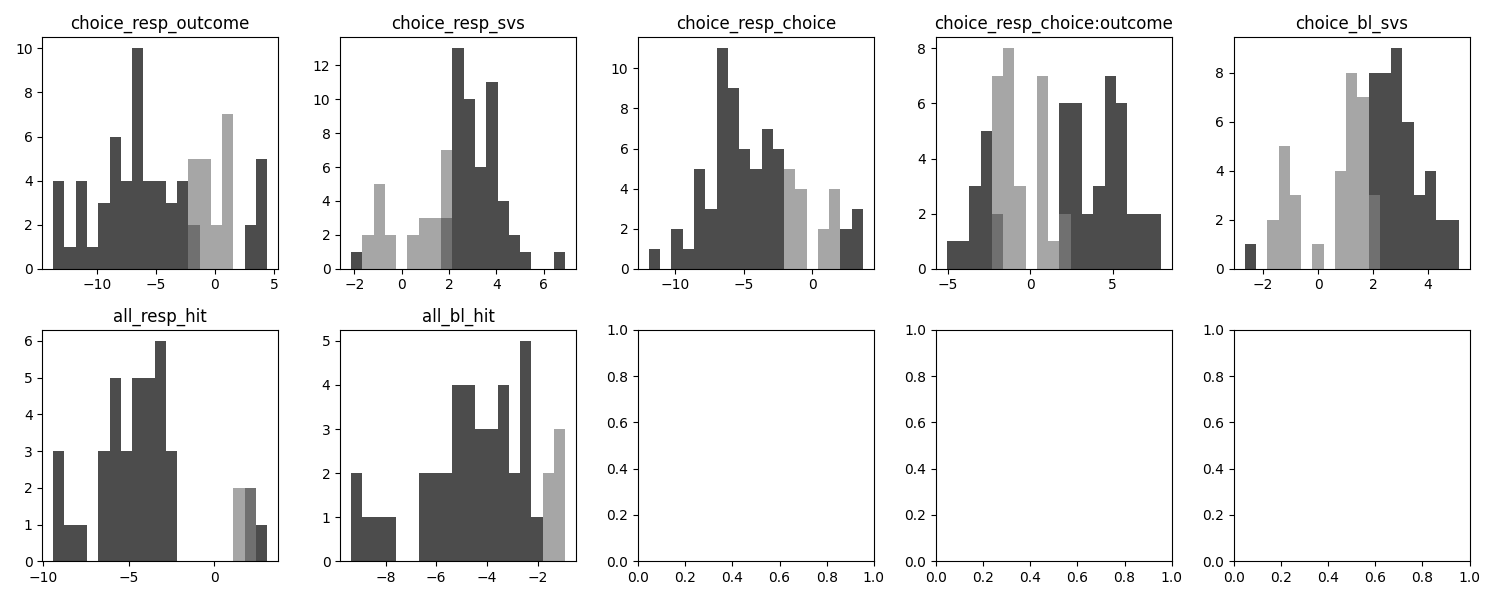

In [145]:
# histogram all cols in pupil_model_params_to_check
fig, axes = plt.subplots(int(np.ceil(len(pupil_model_params_to_check)/5)), 5, figsize=(3 * 5, 3 * int(np.ceil(len(pupil_model_params_to_check)/5))))
for feature_ind, feature in enumerate(pupil_model_params_to_check):
    ax = axes[feature_ind // 5, feature_ind % 5]
    data = session_features_combined[feature].dropna()
    edges = np.linspace(np.nanmin(data.values), np.nanmax(data.values), 20)
    edges[-1] += 0.01
    edges[0] -= 0.01
    if feature + '_min_p' in session_features_combined.columns:
        sig_mask = session_features_combined[feature + '_min_p'] < 0.05
        ax.hist(session_features_combined.loc[sig_mask, feature].dropna(), bins=edges, alpha=0.7, label='p < 0.05', facecolor = 'k')
        ax.hist(session_features_combined.loc[~sig_mask, feature].dropna(), bins=edges, alpha=0.7, label='p >= 0.05', facecolor = 'gray')
    else:
        ax.hist(data, bins=edges, facecolor = 'k', alpha=0.7)
    ax.set_title(feature)
plt.tight_layout()
fig.savefig(fname = os.path.join(pupil_folder, 'pupil_model_feature_histograms.pdf'))
fig.savefig(fname = os.path.join(pupil_folder, 'pupil_model_feature_histograms.svg'))

# Compare with waveforms

In [ ]:
print(wf_features.columns)

In [ ]:
wf_features_to_check = ['half_w', 'trough_w', 'pre_half',
       'post_half', 'post_w', 'trough_post_ratio_1D', 'trough_pre_ratio_1D',
       'post_slope', 'post_space', 'pre_slope', 'pre_space', 'symmetry_inte',
        'symmetry_half', 'symmetry_slope', 'symmetry_inte_div',
       'symmetry_half_div', 'symmetry_slope_div', 'score', 'pc1']

pupil_features_to_check = ['baseline_corr', 'dilation_bl_corr', 'dilation_response_corr', 'peak_lag', 'peak_value', 'decay_tau', 'cross_pc_1', 'cross_pc_2']

In [ ]:
# plot all pupil features and waveform features pairwise
fig, axes = plt.subplots(len(pupil_features_to_check), len(wf_features_to_check), figsize=(2 * len(wf_features_to_check), 2 * len(pupil_features_to_check)))
for i, pupil_col in enumerate(pupil_features_to_check):
    for j, wf_col in enumerate(wf_features_to_check):
        ax = axes[i, j]
        x = features_combined[wf_col]
        y = features_combined[pupil_col]
        mask_xy = (x.isna() == False) & (y.isna() == False) & (features_combined['be_filter'].values)
        x_valid = x[mask_xy]
        y_valid = y[mask_xy]
        if len(x_valid) > 2:
            r, p = pearsonr(x_valid, y_valid)
            if p < 0.05:
                ax.scatter(x_valid, y_valid, color='red', alpha=0.5, s=10)
                ax.set_title(f'r={r:.2f}, p={p:.3f}', color='red')
            else:
                ax.scatter(x_valid, y_valid, color='k', alpha=0.5, s=10)
                ax.set_title(f'r={r:.2f}, p={p:.3f}')
        else:
            r, p = np.nan, np.nan
        ax.set_xlabel(wf_col)
        ax.set_ylabel(pupil_col)
        
plt.tight_layout()
# save figure
fig.savefig(os.path.join(pupil_folder, 'pupil_wf_feature_correlations.png'), dpi=300)
fig.savefig(os.path.join(pupil_folder, 'pupil_wf_feature_correlations.pdf'))

# Compare with task responses

In [ ]:
beh_var_to_check = features_to_plot = ['T_response_svs_hit', 'T_outcome_com_mc', 'T_outcome_l_mc', 'T_outcome_e_mc',
                    'theta_com', 'theta_l', 'theta_e', 'coef_outcome|(|coef_outcome| + |coef_Q|)',
                    'T_response_svs_hit', 'T_response_hit_all', 'T_baseline_hit_all', 'T_baseline_svs_hit']
# plot all behavior model features and pupil features pairwise
fig, axes = plt.subplots(len(pupil_features_to_check), len(beh_var_to_check), figsize=(2 * len(beh_var_to_check), 2 * len(pupil_features_to_check)))
for i, pupil_col in enumerate(pupil_features_to_check):
    for j, beh_col in enumerate(beh_var_to_check):
        ax = axes[i, j]
        x = features_combined[beh_col]
        y = features_combined[pupil_col]
        mask_xy = (x.isna() == False) & (y.isna() == False) & (features_combined['be_filter'].values)
        x_valid = x[mask_xy]
        y_valid = y[mask_xy]
        if len(x_valid) > 2:
            r, p = pearsonr(x_valid, y_valid)
            if p < 0.05:
                ax.scatter(x_valid, y_valid, color='red', alpha=0.5, s=10)
                ax.set_title(f'r={r:.2f}, p={p:.3f}', color='red')
            else:
                ax.scatter(x_valid, y_valid, color='k', alpha=0.5, s=10)
                ax.set_title(f'r={r:.2f}, p={p:.3f}')
        else:
            r, p = np.nan, np.nan
        ax.set_xlabel(beh_col)
        ax.set_ylabel(pupil_col)
plt.tight_layout()
# save figure
fig.savefig(os.path.join(pupil_folder, 'pupil_beh_feature_correlations.png'), dpi=300)
fig.savefig(os.path.join(pupil_folder, 'pupil_beh_feature_correlations.pdf'))


# Correlation with basicephys features

In [ ]:
basic_ephys_df.columns

In [ ]:
be_features = ['bl_mean', 'response_rate', 'response_bias', 'response_diff', 'bl_diff', 'bl_response_corr', 'pc_1', 'pc_2', 'pc_3']
# plot all basic ephys features and pupil features pairwise
fig, axes = plt.subplots(len(pupil_features_to_check), len(be_features), figsize=(2 * len(be_features), 2 * len(pupil_features_to_check)))
for i, pupil_col in enumerate(pupil_features_to_check):
    for j, be_col in enumerate(be_features):
        ax = axes[i, j]
        x = features_combined[be_col]
        y = features_combined[pupil_col]
        mask_xy = (x.isna() == False) & (y.isna() == False) & (features_combined['be_filter'].values)
        x_valid = x[mask_xy]
        y_valid = y[mask_xy]
        if len(x_valid) > 2:
            r, p = pearsonr(x_valid, y_valid)
            if p < 0.05:
                ax.scatter(x_valid, y_valid, color='red', alpha=0.5, s=10)
                ax.set_title(f'r={r:.2f}, p={p:.3f}', color='red')
            else:
                ax.scatter(x_valid, y_valid, color='k', alpha=0.5, s=10)
                ax.set_title(f'r={r:.2f}, p={p:.3f}')
        else:
            r, p = np.nan, np.nan
        ax.set_xlabel(be_col)
        ax.set_ylabel(pupil_col)

plt.tight_layout()

In [ ]:
a = [5.8, 5.9, ]